<h1 style="text-align: center"> Assignment #5 </h1>


<h4 style="text-align: center"> Kevin McManus </h4>
<h4 style="text-align: center"> Student ID: 109702479</h4>

In [1]:
import numpy as np
import pandas as pd

## 1. Instrument Class
> The Instrument class will be defined as follows: 


In [2]:
class Instrument:
    def __init__(self,name='Unnamed', nlam = 100, lam_min = 100., lam_max = 1000., area = 1.):
        """
        Constructs an Instrument object.

        Arguments:
            nlam: int; number of wavelength bins
            lam_min, lam_max: float; wavelength minimum and maximum, NANOMETERS
            area: float or ndarray of floats, collector area, meters; if ndarray, length must match nlam parameter
        """
        self.name = name
        self.nlam = nlam
        self.lam_min = lam_min
        self.lam_max = lam_max
        self.lam = np.linspace(lam_min, lam_max, nlam )
        self.lambin = (lam_max-lam_min)/float(nlam)
        self.area = area

    def __repr__(self):
        reprstr='Instrument Object; '+ ', '.join([f'{p} = {getattr(self,p)}' for p in ['name', 'nlam', 'lam_min', 'lam_max', 'area']])
        return reprstr

    def lam_meters(self):
        """
        Computes and returns the intruments wavelength property to meters
        """

        nm_per_meter = 1e9
        return self.lam/nm_per_meter

    def binwidth_m(self):
        """
        Return the width in meters of the instruments wavelength bins.
        """
        nm_per_meter = 1e9
        return self.lambin/nm_per_meter

> Create one instrument called ‘Generic” by the line:

In [3]:
I=Instrument(name='Generic', nlam = 101, lam_min = 100., lam_max = 2100., area = 1.)
I

Instrument Object; name = Generic, nlam = 101, lam_min = 100.0, lam_max = 2100.0, area = 1.0

## 2. Model a Star

>Use the Star() class from assignment 2. Create an instance of the Star class called “Sun10” and
put in the characteristics of the Sun, but put the Sun at 10pc.

Below is the Star class from Assignment \#2 with some embellishments for the current assignment. Most of these are unit conversion methods that convert star properties to SI units, For example, the `Star.radius_m()` method returns the star's radius in meters converting from the input units of solar radii.


In [4]:
class Star():
    # required star properties the Star object keeps track of
    _starprops = ['ra','dec','distance','radius','mass','teff']
    # properties to coerce to floats
    _starpropfloats = ['distance','radius','mass','teff']
    
    def __init__(self, name, **kwargs):
        """
        Constructs a Star Object.

        Arguments:
            ra: string, right ascension (J2000) hh:mm:ss.ssss
            dec: string, declination (J2000) dd:mm:ss.sssss
            distance: float, pc
            radius: float, soloar radii
            mass: float, solar masses
            teff: float, effective temperature, K
        """      
        self.name = name # required
        
        #required properties; will bomb if property not supplied
        for prop in Star._starprops:
            setattr(self, prop, kwargs.pop(prop))

        #make sure the props that are supposed to be floats are floats
        for prop in Star._starpropfloats:
            setattr(self, prop, float(getattr(self, prop)))
       
    def __repr__(self):
        str = f'Star object: name: {self.name}'
        for prop in Star._starprops:
            v = getattr(self, prop, None)
            if v is not None:
                str += f', {prop}: {v}'            
        return str

    def radius_m(self):
        """
        Returns star radius in m.
        """
        sun_r_m = 6.957e+08 # m
        return self.radius*sun_r_m

    def distance_m(self):
        """
        Returns distance to star in m.
        """
        m_per_pc = 3.085677581491367e+16
        dist_m = self.distance*m_per_pc
        return dist_m
        
    def surface_area(self):
        """
        Returns surface area of star in m^2.
        """
        r = self.radius_m()
        return 4*np.pi*r**2
        
    def mass_g(self):
        """
        Returns star mass in kg.
        """
        sun_m_kg = 1.98841e+30 #kg
        return self.mass*sun_m_kg

    def Wien(self):
        """
        Computes and returns wavelength (in nm) of maximum flux given star's temperature
        """
        nm_per_meter = 1e9
        lmbda_max = 0.0029/self.teff #meters
        return lmbda_max*nm_per_meter

    def surface_flux(self):
        """
        Computes flux on the surface of the star using StefanBoltzmann law
        Returns:
            flux: float, W m^-2
        """
        sb =  5.67037e-08 #stefan boltzmann const. W / (K4 m2)
        self.flux = flux = sb*np.power(self.teff,4)
        return flux

    def luminosity(self):
        """
        Computes and returns star's luminosity (in Watts) from its radius and temperature
        """
        sa = self.surface_area()
        flux = self.surface_flux()
        return flux*sa

    def to_dict(self):
        """
        Returns a dict of star properties.
        """
        d = dict([(prop,getattr(self,prop,None)) for prop in ['name']+Star._starprops])
        return d

In [22]:
help(Star.__init__)

Help on function __init__ in module __main__:

__init__(self, name, **kwargs)
    Constructs a Star Object.
    
    Arguments:
        ra: string, right ascension (J2000) hh:mm:ss.ssss
        dec: string, declination (J2000) dd:mm:ss.sssss
        distance: float, pc
        radius: float, soloar radii
        mass: float, solar masses
        teff: float, effective temperature, K



In [5]:
mintaka = Star('Mintaka', ra='05:32:00.4009', dec='-00:17:56.7424',
            distance=380, mass= 24, teff=29500, radius=16.5)

#Sun at 10pc
Sun10 = Star('Sun10', ra='00:00:04', dec='00:00:25',
            distance=10, mass= 1, teff=5780, radius=1.0)


In [6]:
Sun10

Star object: name: Sun10, ra: 00:00:04, dec: 00:00:25, distance: 10.0, radius: 1.0, mass: 1.0, teff: 5780.0

### Model Class

>Copy the Model Class from Chapter4.ipynb into your surname_5.ipynb and rename the class
MyModel(). Create an empty instance of MyModel called S10. 

`Model` class from the text, with additional `plot_spectrum` class method.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class Model:
    def __init__(self,name="undefined"):
        self.name = name
        self.npt = 0
        self.x = []
        self.y = []
        self.cumy = []
        self.dx = []

    def __repr__(self):
        reprstr = f'Model object; name: {self.name}'
        return reprstr

        
    def Xarray(self,npt=10,xmin=0.,xmax=1.):
        self.npt = npt
        self.x = np.linspace(xmin, xmax, npt, endpoint=False)
        self.dx = (xmax-xmin)/(npt)
        
    def PlotModel(self):
        plt.title(self.name)
        plt.plot(self.x,self.y)
        plt.show()

    def plot_spectrum(self, **kwargs):
        ax = kwargs.pop('ax', None)
        title = kwargs.pop('title', self.name)
        which = kwargs.pop('which','flux')

        drawstyle = None
        if which == 'flux':
            obsval = self.f_obs_lambda
        elif which == 'luminosity':
            obsval = self.luminosity_lambda
        elif which == 'instrument':
            obsval = self.inst_flux_lambda
            drawstyle = 'steps'
        else:
            raise ValueError(f'which must be \'flux\' or \'luminosity\'; which: {str(which)}')

        nm_per_m = 1e9
        
        fig = None
        if ax is None:
            fig, ax = plt.subplots()

        lmbda_nm = self.lmbda*nm_per_m

        ax.plot(lmbda_nm, obsval, drawstyle = drawstyle, **kwargs)

        ax.set_xlabel(r'$Wavelength (nm)$')
        ax.set_ylabel(r'$Joule$')
        ax.set_title(title)     



### `BlackBody` Class Method
> Add a function called Blackbody() to MyModel. It will have three input parameters: an instance
of the Star class, an instance of the Instrument class, and an observing time in seconds.
Blackbody will take the wavelength array of the instrument class and the temperature of the star,
and will use the Planck function to predict the energy recorded in each bin of the instrument
during the specified observing time.

The blackbody or Planck equation is:
$$
B_\lambda(T) = \frac{2hc^2}{\lambda^5}\frac{1}{e^\frac{hc}{\lambda k_B T} -1}
$$
This equation yields the energy intensity of a unit of area radiating on the surface of star. To get the flux on the surface of the star, this quantity  must be integrated over the solid angle radiating outward.
$$
f_\lambda = \int\limits_{\phi=0}^{2\pi}\int\limits_{\theta=0}^{\pi/2}B_\lambda(T) \cos \theta \sin \theta d \theta d \phi
$$
which works out to:
$$
f_\lambda = \pi B_\lambda(T)
$$
To get the star's luminosity at a particular wavelength, $L_\lambda$ the flux must be multiplied by the surface area of the star. That is:
$$
L_\lambda = f_\lambda*4\pi R_{star}^2
$$
And, finally, to predict the flux an observer measures at some distance $D$ from the star, divide by $4\pi D^2$ as in:
$$
\begin{align*}
f_{\lambda,obs} &= L_\lambda /4\pi D^2 \\
&= f_\lambda*4\pi R_{star}^2/4\pi D^2 \\
&= f_\lambda R_{star}^2/D^2
\end{align*}
$$

In [8]:
#class method for Model object
def BlackBody(self, star, inst, obstime):
        #some constants(mks units)
        c = 2.99792e+08 #m s^-1; speed of light
        h = 6.62607e-34 #J s; Planck's constant
        k = 1.38065e-23 #J k^1- ; Boltzmann's constant

        self.lmbda = lmbda = inst.lam_meters()
        temp = star.teff

        #construct the intensity (B_lambda) as product of two terms
        #first term:
        first_term = (2*h*c**2)/np.power(lmbda, 5)

        #second term:
        expnt = h*c/(lmbda*k*temp)
        second_term = 1/(np.exp(expnt)-1)

        B_lambda = first_term*second_term #units: J s^-1 m^-2 m^-1 steradian^-1

        #B_lambda is an infintesimally small area on body's surface radiating isotropically
        #Intergrate over surface of the area that is facing outward
        #this integration gets rid of the steradian term above
        #See Maoz, p12, eq 2.5
        f_lambda = np.pi*B_lambda

        #f_lambda need to be multiplied by surface area of star to get its luminosity
        L_lambda = f_lambda*star.surface_area()
        self.luminosity_lambda = L_lambda

        #flux at the observer
        f_obs_lambda = L_lambda/(4*np.pi*star.distance_m()**2)
        self.f_obs_lambda = f_obs_lambda

        #flux in the instrument bins
        #multiply the spectrum by the bin width, bin area and obstime to get the energy in each instrument bin
        dx = inst.binwidth_m()
        inst_flux = f_obs_lambda*dx*inst.area*obstime

        #update the model with the flux values
        self.inst_flux_lambda = inst_flux

def integrate_spectrum(self, which='luminosity'):
        """
        Approximates definite integral of luminosity over frequency range. Returns result.

        Arguments:
                which: string; either 'luminosity' or 'flux'; integrates the spectrum at the star or observer
        """
        if which == 'flux':
            obsval = self.f_obs_lambda
        elif which == 'luminosity':
            obsval = self.luminosity_lambda
        else:
            raise ValueError(f'which must be \'flux\' or \'luminosity\'; which: {str(which)}')
        
        Lum_approx = np.trapz(obsval, self.lmbda)
        return Lum_approx

Model.BlackBody = BlackBody
Model.integrate_spectrum = integrate_spectrum

## Validate BlackBody Calculations

Calculate a spectrum for the Sun using $T=5780$, integrate over that spectrum and compare the result to the published luminosity of the Sun.

>Run Blackbody for Sun10 for time=1.0 seconds. Multiply the predicted spectrum by $4*np.pi D^2$
(D=10pc) to get the Joules/bin at the star. Print np.sum(S10.y). That should be the luminosity of
the Sun to within about 25%. If it deviates by much more than that, you have a problem in the
use of the Planck function.

First run with Sun (not at 10 pc but rather at 1 AU) so that we can directly compare the resulting luminosity to published luminoisty of the Sun

In [23]:
L_sun = 3.828e+26 #(Watt) calibration standard from astropy and in agreement with published sources

#good ole Mr. Sun, ra and dec as of mid-March, temp from Wikipedia
#distance = 1 AU in pc
Sun = Star('Sun', ra='00:00:04', dec='00:00:25',
            distance=4.848e-06, mass= 1, teff=5780, radius=1.0)
print(Sun)

bb_sun =  Model(name='Sun BlackBody Model') #not to be confused with bb_king
print(bb_sun)

#instantiate the black body model
bb_sun.BlackBody(star = Sun, inst=I, obstime=1)

#integrate over the luminosity spectrum at the star to get the total luminosity
int_spec = bb_sun.integrate_spectrum(which = 'luminosity')

#compare integrated spectrum  to calibration standard
print(f'Luminosity from integrated black body spectrum: {int_spec:.3e} Watt')
print(f'Published Solar Luminosity from Astropy: {L_sun:.3e} Watt')
print(f'Ratio: {int_spec/L_sun:.3f}')

Star object: name: Sun, ra: 00:00:04, dec: 00:00:25, distance: 4.848e-06, radius: 1.0, mass: 1.0, teff: 5780.0
Model object; name: Sun BlackBody Model
Luminosity from integrated black body spectrum: 3.644e+26 Watt
Published Solar Luminosity from Astropy: 3.828e+26 Watt
Ratio: 0.952


In the cell above, we calculate the luminosity of the Sun by integrating over its modeled spectrum and compare the result to Sun's published luminosity.
The `integrate_spectrum()` method of the `Model` class performs the spectral integration and produces a result that is within 5% of the published luminosity of the sun.

Now, redo the calculations, this time as requested with a Sun-like object at 10 pc distant.

In [24]:
L_sun = 3.828e+26 #calibration standard from astropy and in agreement with published sources

#Sun at 10pc
Sun10 = Star('Sun10', ra='00:00:04', dec='00:00:25',
            distance=10, mass= 1, teff=5780, radius=1.0)
print(Sun10) 

bb_sun10 =  Model(name='Sun (at 10 pc) BlackBody Model')
print(bb_sun10)

obstime = 1 #second

bb_sun10.BlackBody(star = Sun10, inst=I, obstime=obstime)

#calculate the flux at the observer and project out to the star
int_spec10 = bb_sun10.integrate_spectrum(which='flux')*4*np.pi*Sun10.distance_m()**2
#energy observed at the collector (add up the energy in the detector bins)
inst_energy = bb_sun10.inst_flux_lambda.sum()
#object luminosity implied by the total observed energy
inst_luminosity = inst_energy*4*np.pi*Sun10.distance_m()**2/obstime #to convert to watts

#summarize results
print(f'Luminosity from integrated black body (flux) spectrum: {int_spec10:.3e} Watt')
print(f'Published Solar Luminosity from Astropy: {L_sun:.3e} Watt')
print(f'Ratio: {int_spec10/L_sun:.3f}')

print(f'Total Energy Observed by instrument: {inst_energy:.3e} J, '
        f'Implied object luminosity: {inst_luminosity:.3e} W')
print(f'Ratio implied/actual luminosity: {inst_luminosity/L_sun:.3f}')

Star object: name: Sun10, ra: 00:00:04, dec: 00:00:25, distance: 10.0, radius: 1.0, mass: 1.0, teff: 5780.0
Model object; name: Sun (at 10 pc) BlackBody Model
Luminosity from integrated black body (flux) spectrum: 3.644e+26 Watt
Published Solar Luminosity from Astropy: 3.828e+26 Watt
Ratio: 0.952
Total Energy Observed by instrument: 3.017e-10 J, Implied object luminosity: 3.610e+26 W
Ratio implied/actual luminosity: 0.943


The object luminosity implied by the instrument readings is a little bit below the luminosity implied by integrating the theoretical flux at the instrument or the wavelength dependent luminosity at the object.
This is because summing the instrument bin values is a more crude approximation to the definite integral than that produced by `np.trapz` used in `Model.integrate_spectrum`.
But both calculations are with 6% of the true value, which validates the implementation of the `Model.BlackBody` class method.

### Predict Spectrum at Instrument

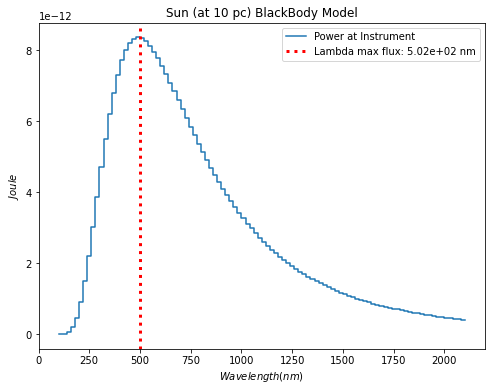

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
bb_sun10.plot_spectrum(ax=ax, which='instrument', label='Power at Instrument')
max_flux= Sun10.Wien()
ax.axvline(max_flux, color='red', ls=':', lw=3, label=f'Lambda max flux: {max_flux:.2e} nm')
ax.legend()

The figure above shows the energy that would be observed in each frequency bin of the detector. The dotted red vertical line shows the bin (in this case, the bin corresponding to 502 nm) containing the maximum energy.
The intstrument energy curve is shown with a stepwise line style in order to depict the discrete nature of the instrument frequency bins.

## Spectra of Various Stars

In this section, we simulate the spectra we expect to see by observing various stars.
The stars vary in their distance from the observer, their radius, temperature and mass.

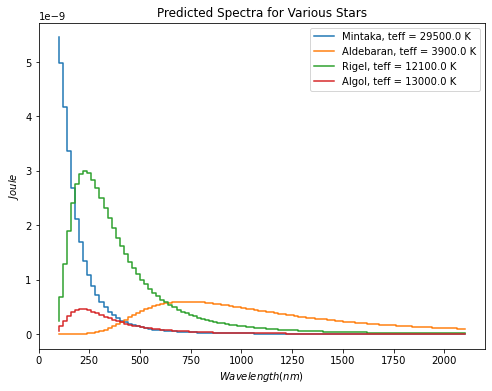

In [25]:
#create dict of star objects
stars = {
        'Mintaka':Star(name='Mintaka', ra='05:32:00.4009', dec='-00:17:56.7424', distance=380, mass=24.0, teff=29500, radius=16.5),
        'Aldebaran':Star(name='Aldebaran', ra='04:35:55.23907', dec='16:30:33.4885', distance=20, mass=1.16, teff=3900, radius=45.1),
        'Rigel': Star(name='Rigel', ra='05:14:32.27210', dec='-08:12:05.8981', distance=264, mass=21.0, teff=12100, radius=78.9),
        'Algol': Star(name='Algol', ra='03:08:10.13245', dec='40:57:20.3280', distance=28, mass=3.17, teff=13000, radius=2.73),
}

#great dict of blackbodies, one for each star, all stars observed by same instrument
blackbodies = {}
for s in stars:
    bb = Model(name=s)
    bb.BlackBody(star=stars[s], inst=I, obstime=1)
    blackbodies[s]= bb

#plot the predicted observed spectrum of each star on the same graph
fig, ax = plt.subplots(figsize=(8,6))
for bb, s in zip(blackbodies, stars):
    blackbodies[bb].plot_spectrum(ax=ax, which='instrument', 
            label=f'{blackbodies[bb].name}, teff = {stars[s].teff} K')

ax.set_title('Predicted Spectra for Various Stars')
ax.legend()

In the plot above, the shape of the spectra reflects the stars' temperatures, with the hotter stars peaking at shorter wavelengths.  The height of the curves and thus the total energy observed will increase with the ratio of $\frac{R_{star}^2}{D_{star}^2}$.

Compare the spectra of Rigel (green curve) and Algol (red curve) in the figure above. The two stars have roughly the same temperatures, so their spectra both peak at approximately 250 nm. Rigel is approximately 9.5 times more distant than Algol, however, Rigel's radius is almost 29 times that of Rigel. The ratios of squared radii to squared distances are $4.5\times 10^{-17}$ and $4.8\times 10^{-18}$ for Rigel and Algol, respectively or Rigel is an order of magnitude larger. This is why the spectrum of Rigel shows so much amplitude than that of Algol.

In [14]:
for s in ['Rigel', 'Algol']:
    print(f'Star: {s} r^2/d^2: {(stars[s].radius_m()/stars[s].distance_m())**2:.3e}')


Star: Rigel r^2/d^2: 4.540e-17
Star: Algol r^2/d^2: 4.832e-18


## Mintaka Luminosity

The star Mintaka is almost five times hotter than our Sun, 24 times more massive and 16 times the diameter. How bright is this star?

In [15]:
#what do we know about Mintaka?
stars['Mintaka']

Star object: name: Mintaka, ra: 05:32:00.4009, dec: -00:17:56.7424, distance: 380.0, radius: 16.5, mass: 24.0, teff: 29500.0

The distance, radius, mass and effective temperature data for the star Mintaka come from the paper in the [References](#references) section via [Wikipedia](https://en.wikipedia.org/wiki/Mintaka)
The authors calculate luminosity to be $log_{10}L_{Mintaka}L_\odot = 5.28\pm 0.05$ which works out to $L_{Mintaka} = 1.91\times10^5 L_\odot$ in the range between $1.70\times10^5 L_\odot$ and $2.14\times10^5 L_\odot$.

Below, we will calculate $L_{Mintaka}$ via the `Star.luminnosity()` class method which uses the Stefan-Boltzmann law and compare it to the published result.

In [16]:
#Compare calculated luminosity to that of sun
print('Mintaka Luminosity: {:.2e} L_sun'.format(stars['Mintaka'].luminosity()/L_sun))

Mintaka Luminosity: 1.86e+05 L_sun


Which is well within the range reported by the paper.

We now compare luminosity calculated by integrating the spectrum:

In [17]:
int_spec = blackbodies['Mintaka'].integrate_spectrum(which='luminosity')
print(f'Integrated Spectrum: {int_spec/L_sun:.2e} L_sun')

Integrated Spectrum: 1.37e+05 L_sun


Mintaka's spectrum, when integrated over the range of our `I` instrument shows only about 70% of the luminosity reported in the paper.
Referring to the spectrum plot above, notice that Mintaka's spectrum does not display the Wien side of the spectrum (at short wave lengths).
This suggests that our instrument is not detecting a large portion of the spectrum that Mintaka emits.

To test this theory we improve the instrument such that it now detects wavelengths as small as 10 nm, versus the original detector's lower limit of 100 nm.

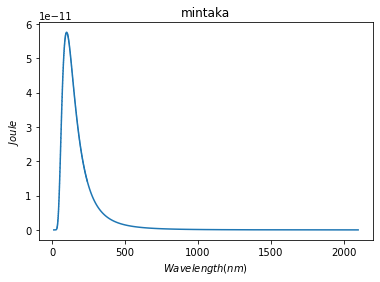

In [18]:
#increase the bandwidth of the instrument
I2=Instrument(name='Xray detector', nlam = 10001, lam_min = 10., lam_max = 2100., area = 1.)
bb_mintaka = Model('mintaka')
bb_mintaka.BlackBody(inst=I2, star=stars['Mintaka'], obstime=1)
bb_mintaka.plot_spectrum(which='instrument')

With our new instrument, we are able to detect high frequency (short wavelength) portion of the spectrum. The Weins portion of the Planck curve is now readily apparent.

Integrating this spectrum yields:

In [19]:
int_spec = bb_mintaka.integrate_spectrum(which='luminosity')
print(f'Integrated Spectrum: {int_spec/L_sun:.2e} L_sun')

Integrated Spectrum: 1.86e+05 L_sun


which is now consistent with the luminosity reported by the paper and with luminosity calculated from the Stefan-Boltzmann equation.

**Awesome!!** Mintaka is 186,000 times brighter than our Sun!!

## References
### Mintaka
```bibtex
@article{2015,
   title={A COORDINATED X-RAY AND OPTICAL CAMPAIGN OF THE NEAREST MASSIVE ECLIPSING BINARY,δORIONIS Aa. IV. A MULTIWAVELENGTH, NON-LTE SPECTROSCOPIC ANALYSIS},
   volume={809},
   ISSN={1538-4357},
   url={http://dx.doi.org/10.1088/0004-637X/809/2/135},
   docurl={https://arxiv.org/pdf/1503.03476.pdf},
   DOI={10.1088/0004-637x/809/2/135},
   number={2},
   journal={The Astrophysical Journal},
   publisher={American Astronomical Society},
   author={Shenar, T. and Oskinova, L. and Hamann, W.-R. and Corcoran, M. F. and Moffat, A. F. J. and Pablo, H. and Richardson, N. D. and Waldron, W. L. and Huenemoerder, D. P. and Maíz Apellániz, J. and Nichols, J. S. and Todt, H. and Nazé, Y. and Hoffman, J. L. and Pollock, A. M. T. and Negueruela, I.},
   year={2015},
   month={Aug},
   pages={135} }
```


## Appendix: Constants Used in this Notebook

In [20]:
import astropy.constants as const
from tabulate import tabulate

constants = ['c', 'sigma_sb', 'k_B', 'h', 'L_sun', 'R_sun', 'M_sun','au','pc']
cons_data = [(cn, getattr(const, cn).name,getattr(const, cn).value, getattr(const, cn).unit) for cn in constants]
col_names = ['Name', 'Description','Value', 'Units']
print(tabulate(cons_data, headers=col_names))

Name      Description                      Value  Units
--------  -------------------------  -----------  -----------
c         Speed of light in vacuum   2.99792e+08  m / s
sigma_sb  Stefan-Boltzmann constant  5.67037e-08  W / (K4 m2)
k_B       Boltzmann constant         1.38065e-23  J / K
h         Planck constant            6.62607e-34  J s
L_sun     Nominal solar luminosity   3.828e+26    W
R_sun     Nominal solar radius       6.957e+08    m
M_sun     Solar mass                 1.98841e+30  kg
au        Astronomical Unit          1.49598e+11  m
pc        Parsec                     3.08568e+16  m
